In [7]:
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import glob 
import numpy as np
import pandas as pd
from hidimstat.statistical_tools.multiple_testing import fdp_power

import sys, os

notebook_dir = os.getcwd()

sys.path.append(os.path.abspath(os.path.join(notebook_dir, "..", "src")))

from utils import _bhq_threshold, knockoff_threshold


cor=0.3
alpha = 0.05

y_method = 'hidimstats'
fdr=0.1
ns = [100, 200, 500]
p=int(max(ns)/2)
csv_files = glob.glob(f"csv/KO/{y_method}_cor{cor}_seed105.csv")
df = pd.concat((pd.read_csv(f) for f in csv_files), ignore_index=True)


# Display the first few rows of the DataFrame
print(df.head())

powers = []
fdps = []
auc_scores = []
methods_BH = {'CPI_KO_Wilcox', "dCRT", "HRT"}

imp_KO = []
imp_CPI_KO = []
null_KO = []
null_CPI_KO = []

for index, row in df.iterrows():
    n = int(row["n"])
    p=int(n/2)
    imp = row.filter(like="imp").values[:p]
    imp = np.array(imp, dtype=float)  # force numeric
    imp = np.nan_to_num(imp, nan=1.0, posinf=1.0, neginf=1.0)
    non_zero_index = row.filter(like="tr_V").values[:p].astype(int)
    if row["method"] in methods_BH:
        threshold = _bhq_threshold(imp, fdr=fdr)
        print(threshold)
        selected = np.where(imp <=threshold)[0]
        auc = roc_auc_score(non_zero_index, -imp)
    else:
        ko_thr = knockoff_threshold(imp, fdr=fdr)
        selected = np.where(imp >= ko_thr)[0]
        auc = roc_auc_score(non_zero_index, imp)
        if row["method"] == 'Knockoff':
            imp_KO.append(imp[non_zero_index])
            mask = np.ones(len(imp), dtype=bool)
            mask[non_zero_index] = False
            null_KO.append(imp[mask]) 
        elif row["method"] == 'CPI_KO':
            imp_CPI_KO.append(imp[non_zero_index])
            mask = np.ones(len(imp), dtype=bool)
            mask[non_zero_index] = False
            null_CPI_KO.append(imp[mask])
    auc_scores.append(auc)
    # compute selections
    fdp, power = fdp_power(selected, non_zero_index)
    fdps.append(fdp)
    powers.append(power)

     method    n  tr_V0      imp0  tr_V1      imp1  tr_V2      imp2  tr_V3  \
0  Knockoff  100    1.0  0.743543    1.0  0.730864    1.0  0.710983    1.0   
1  Knockoff  200    1.0  0.727101    1.0  0.737637    1.0  1.004210    1.0   
2  Knockoff  500    1.0  0.609590    1.0  1.003133    1.0 -0.110925    1.0   
3    CPI_KO  100    1.0  0.730064    1.0  0.571563    1.0  0.441353    1.0   
4    CPI_KO  200    1.0  0.608381    1.0  0.476482    1.0  0.677714    1.0   

       imp3  ...  tr_V245    imp245  tr_V246    imp246  tr_V247    imp247  \
0  0.672844  ...      NaN       NaN      NaN       NaN      NaN       NaN   
1  0.694715  ...      NaN       NaN      NaN       NaN      NaN       NaN   
2  1.003127  ...      1.0  0.642726      1.0  1.099458      1.0  0.226768   
3  0.375773  ...      NaN       NaN      NaN       NaN      NaN       NaN   
4  0.309385  ...      NaN       NaN      NaN       NaN      NaN       NaN   

   tr_V248    imp248  tr_V249    imp249  
0      NaN       NaN      

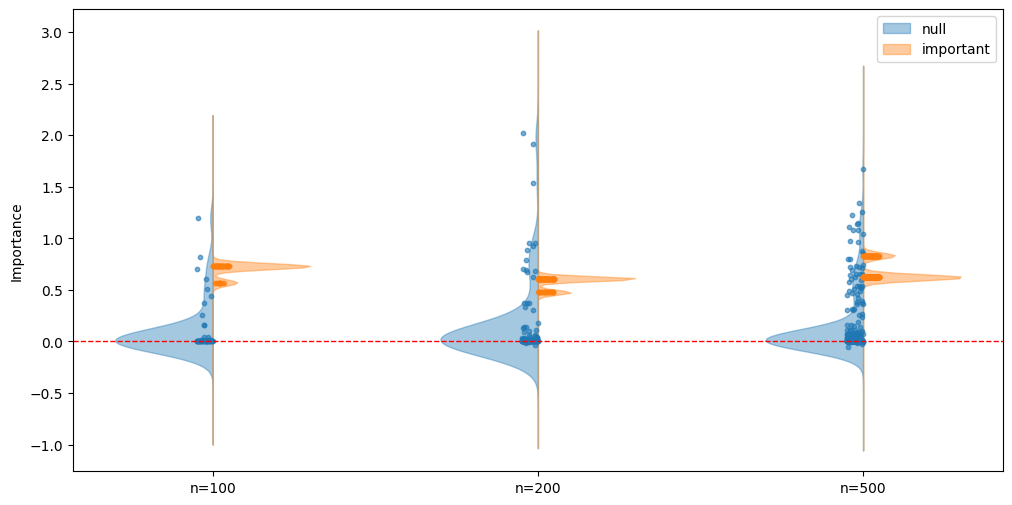

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(figsize=(12,6))

for i, (a, b) in enumerate(zip(null_CPI_KO, imp_CPI_KO)):
    # --- KDE para A ---
    kde_a = gaussian_kde(a)
    y_vals = np.linspace(min(a.min(), b.min())-1, max(a.max(), b.max())+1, 200)
    density_a = kde_a(y_vals)
    density_a = density_a / density_a.max() * 0.3  # normalizar ancho
    
    # --- KDE para B ---
    kde_b = gaussian_kde(b)
    density_b = kde_b(y_vals)
    density_b = density_b / density_b.max() * 0.3
    
    # --- Dibujar densidades (lado izq A, lado der B) ---
    ax.fill_betweenx(y_vals, i - density_a, i, alpha=0.4, color="C0", label="null" if i==0 else "")
    ax.fill_betweenx(y_vals, i, i + density_b, alpha=0.4, color="C1", label="important" if i==0 else "")
    
    # --- Dibujar puntos ---
    jitter_a = np.random.uniform(-0.05, 0.0, size=len(a))
    jitter_b = np.random.uniform(0.0, 0.05, size=len(b))
    ax.scatter(np.full_like(a, i) + jitter_a, a, color="C0", alpha=0.6, s=10)
    ax.scatter(np.full_like(b, i) + jitter_b, b, color="C1", alpha=0.6, s=10)

ax.set_xticks(range(len(null_CPI_KO)))
ax.set_xticklabels([f"n={i}" for i in ns])
#ax.set_xlim(-1, N)
ax.set_ylabel("Importance")
ax.legend()

ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.show()


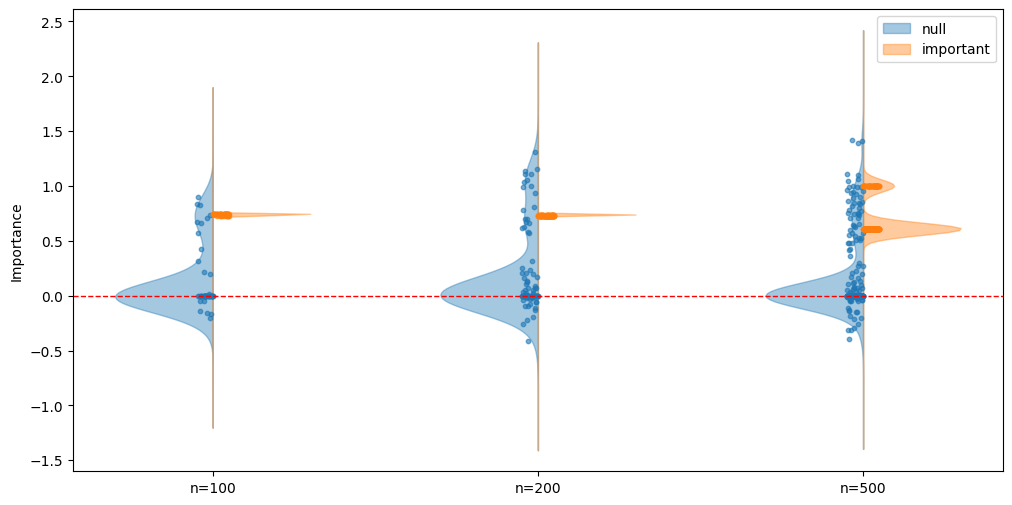

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


fig, ax = plt.subplots(figsize=(12,6))

for i, (a, b) in enumerate(zip(null_KO, imp_KO)):
    # --- KDE para A ---
    kde_a = gaussian_kde(a)
    y_vals = np.linspace(min(a.min(), b.min())-1, max(a.max(), b.max())+1, 200)
    density_a = kde_a(y_vals)
    density_a = density_a / density_a.max() * 0.3  # normalizar ancho
    
    # --- KDE para B ---
    kde_b = gaussian_kde(b)
    density_b = kde_b(y_vals)
    density_b = density_b / density_b.max() * 0.3
    
    # --- Dibujar densidades (lado izq A, lado der B) ---
    ax.fill_betweenx(y_vals, i - density_a, i, alpha=0.4, color="C0", label="null" if i==0 else "")
    ax.fill_betweenx(y_vals, i, i + density_b, alpha=0.4, color="C1", label="important" if i==0 else "")
    
    # --- Dibujar puntos ---
    jitter_a = np.random.uniform(-0.05, 0.0, size=len(a))
    jitter_b = np.random.uniform(0.0, 0.05, size=len(b))
    ax.scatter(np.full_like(a, i) + jitter_a, a, color="C0", alpha=0.6, s=10)
    ax.scatter(np.full_like(b, i) + jitter_b, b, color="C1", alpha=0.6, s=10)

ax.set_xticks(range(len(null_CPI_KO)))
ax.set_xticklabels([f"n={i}" for i in ns])
#ax.set_xlim(-1, N)
ax.set_ylabel("Importance")

ax.axhline(y=0, color='red', linestyle='--', linewidth=1)
ax.legend()
plt.show()
